# DEEP LEARNING

Deep learning is a type of machine learning that imitates the way humans gain certain types of knowledge. It uses multiple layers of connected neurons with activation functions to extract features from the input, such as images. Compared to "regular" machine learning, deep learning extracts the features by its own. i.e it assumes nothing about the underlying model to begin fit and is thus very free to adapt.

<div>
    <img src="misc/DL.jpg" width="700"/>
</div>

## k-layer Neural Networks

A k-layer neural network is a network of connected neurons split into k-layers. The layers' size may differ. Between the layer _i-1_ and _i_ one has a non-linear activation function, typically ReLu (f(x) = max(0,x)).

<div>
    <img src="misc/k-layer.png" width="400"/>
</div>


## Training a neural network

The training of a neural network is typically done with stochastic gradient descent based on a specified loss function such as CrossEntropyLoss. Training is usually stopped when the loss on the validation set stops decreasing.


## Hyperparameters

For the simple k-layer neural networks there are two important hyperparameters:

1. _k_, the number of layers
2. _eta_, the learning rate (the factor used to multiply the gradient)

These must be explored in order to get the best results.

# Preprocessing

Before training we need to import an pre-process the data. This is done with our self-developed python packages.

## Import internal utils

First we need to import our internal utils.

In [1]:
# Import the function that imports and pre-processes data
from utils.import_data import importData

# Import the class the tests ML-models
from utils.model_tester import ModelTester
import utils.nicer_plots

## Import the data

We're now ready to import the data. importData() imports the data from .csv-files and saves it into pandas dataFrames. It also performs a standardScaler, scaling the features one by one so their mean = 0 and std = 1.

In [2]:
# The name of the files to be imported
file_data = "data2.csv"
file_labels = "labels2.csv"

# How many of the 3851 features that should be selected (-1 <=> all)
n_features = -1

# The folder the files lies in
directory = "\data\\"

# Import the data
data, labels = importData(file_data, file_labels, directory, n_features, iterations=False)

Number of samples:    102400
Number of features:   3851


## Defining the model

#### [THIS PART IS VERY TECHINCAL AND CAN BE SKIPPED]
If you're not interested in how this is implemented, you can jump to _Model exploration_

With the data imported, we now need to define a new class, using both the SGDClassifier and the RBFSampler. This will make it possible to tune the parameters for the classifier and the sampler **at the same time**.

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self, k = 5, eta = 0.01, lambda_ = 0, optimizer_ = torch.optim.Adam, criterion_ =  torch.nn.CrossEntropyLoss, n_epochs_ = 10):

        # super(Net, self).__init__()
        super().__init__()

        # hyperparameters
        self.k = k
        self.eta = eta
        self.optimizer_ = optimizer_
        self.criterion_ = criterion_
        self.n_epochs_ = n_epochs_
        self.lambda_ = lambda_

        self.D = 3851       # how many features
        self.d_in = 64      # in for final layer
        self.d_out = 2      # out for final layer

        # decrease-factor for every layer
        quotient = (self.D / self.d_in) ** (1 / (k - 1))

        self.hidden = nn.ModuleList()

        out_ = self.D
        for i in range(self.k - 1):
            in_ = out_
            out_ = int(out_ / quotient) + 1

            self.hidden.append(nn.Linear(in_, out_).double())

        self.out = nn.Linear(out_, self.d_out).double()

    def forward(self, x):

        for layer in self.hidden:
            x = F.relu(layer(x))        # go through layer i

        x = self.out(x)                 # final layer

        return x

### Initializing the ModelTester

We're now ready to initialize a ModelTester object. Let's see if it works

In [4]:
# code to setup model environment

# import model
from sklearn.kernel_approximation import RBFSampler

# initialize object
mt = ModelTester(data, labels, Net, k = 5, eta = 0.01, lambda_ = 0.01) # everything after the model are the hyperparameters

# test to see that it was initialized correctly
print(mt.model(**mt.parameters))
print(mt.parameters)

Net(
  (hidden): ModuleList(
    (0): Linear(in_features=3851, out_features=1383, bias=True)
    (1): Linear(in_features=1383, out_features=497, bias=True)
    (2): Linear(in_features=497, out_features=179, bias=True)
    (3): Linear(in_features=179, out_features=65, bias=True)
  )
  (out): Linear(in_features=65, out_features=2, bias=True)
)
{'k': 5, 'eta': 0.01, 'lambda_': 0.01}


Seems like it worked!

### Custom functions

Since the SGD in the class we defined above only can return prediction scores for some losses, we need to create a dummy function that returns a vector of the correct size in some cases. This will render the AUC-score innacurate for incompaitble losses.

In [5]:
# the custom training function
def custom_training(self, x, y):
    model = self.model(**self.parameters)
    
    optimizer = model.optimizer_(model.parameters(), model.eta, weight_decay = model.lambda_)
    criterion = model.criterion_()

    X_train = torch.from_numpy(x)
    y_train = torch.from_numpy(y)

    y_train = y_train.type(torch.LongTensor)

    for epoch in range(model.n_epochs_):
        X_train, y_train = torch.autograd.Variable(X_train), torch.autograd.Variable(y_train)

        model.train()

        optimizer.zero_grad()

        output_train = model(X_train)

        loss_train = criterion(output_train, y_train)

        loss_train.backward()
        optimizer.step()

        # print("\t\tSub-epoch", epoch, "complete")

    return model

In [6]:
# the custom prediction function
def custom_prediction(self, x, model):
    x = torch.from_numpy(x)
    probabilities = model(x)
    pred_train = probabilities # For detaching
    y_pred = np.argmax(pred_train.detach().numpy(), axis=1)

    return y_pred

In [7]:
def custom_predict_proba(self, x, model):
    x = torch.from_numpy(x)
    probabilities = model(x)
    pred_train = probabilities # For detaching
    return pred_train.detach().numpy()[:, 1]

In [8]:
# set the custom functiomn
mt.set_custom_functions(custom_train_model=custom_training, custom_prediction=custom_prediction, custom_predict_proba=custom_predict_proba)

# Model exploration

We're now ready to try the model out. We will explore the following parameters

* k - the number of layers
* eta - the learning rate

In [9]:
# Model parameters
sampling = 'under'

# parameters that will be tested
parameters = {
            'k':[3, 5, 7, 9],
            'eta': 10 ** np.linspace(-3, -1, 5),
            'n_epochs_':[5]}

# Run the grid search
mt.hyperparameter_tuning(n_train = 8, n_test = 2, n_epochs = 5, sampling = sampling, **parameters)

100%|██████████| 20/20 [21:30<00:00, 64.51s/it] 


   Ranking    k         eta    n_epochs_    balanced_accuracy    Standard deviation
---------  ---  ----------  -----------  -------------------  --------------------
        1    3  0.001                 5                  0.5                     0
        2    9  0.01                  5                  0.5                     0
        3    9  0.00316228            5                  0.5                     0
        4    9  0.001                 5                  0.5                     0
        5    7  0.1                   5                  0.5                     0
        6    7  0.0316228             5                  0.5                     0
        7    7  0.01                  5                  0.5                     0
        8    7  0.00316228            5                  0.5                     0
        9    7  0.001                 5                  0.5                     0
       10    5  0.1                   5                  0.5                     0


{'k': 3, 'eta': 0.001, 'n_epochs_': 5}

There doesn't seem to be a clear relationship between the number of layers and the performance. We will thus test with applying regularization when k = 3, to get faster training.

Also note that most combinations get a balanced accuracy of exactly 0.5, which indicates that it guesses only feasible or infeasible.

In [10]:
# Model parameters
sampling = 'under'

# parameters that will be tested
parameters = {
            'k':[3],
            'eta': 10 ** np.linspace(-3, -1, 5),
            'n_epochs_':[5],
            'lambda_':10 **  np.linspace(-5, -1, 5)
        }

# Run the grid search
mt.hyperparameter_tuning(n_train = 8, n_test = 2, n_epochs = 5, sampling = sampling, **parameters)

100%|██████████| 25/25 [09:13<00:00, 22.14s/it]


   Ranking    k         eta    n_epochs_    lambda_    balanced_accuracy    Standard deviation
---------  ---  ----------  -----------  ---------  -------------------  --------------------
        1    3  0.01                  5     0.001              0.500929           0.00185701
        2    3  0.00316228            5     1e-05              0.500388           0.000775004
        3    3  0.001                 5     0.0001             0.500085           0.000694109
        4    3  0.1                   5     0.001              0.5                0
        5    3  0.1                   5     0.0001             0.5                0
        6    3  0.1                   5     1e-05              0.5                0
        7    3  0.0316228             5     0.1                0.5                0
        8    3  0.0316228             5     0.01               0.5                0
        9    3  0.0316228             5     0.001              0.5                0
       10    3  0.0316228

{'k': 3, 'eta': 0.01, 'n_epochs_': 5, 'lambda_': 0.001}

Hmm, there doesn't seem to be a pattern for any of the parameters. Let's try increasing k.

In [11]:
# Model parameters
sampling = 'under'

# parameters that will be tested
parameters = {
            'k':[5],
            'eta': 10 ** np.linspace(-4, -1, 5),
            'n_epochs_':[5],
            'lambda_':10 **  np.linspace(-5, -1, 5)}

# Run the grid search
mt.hyperparameter_tuning(n_train = 8, n_test = 2, n_epochs = 5, sampling = sampling, **parameters)

100%|██████████| 25/25 [16:43<00:00, 40.13s/it]


   Ranking    k         eta    n_epochs_    lambda_    balanced_accuracy    Standard deviation
---------  ---  ----------  -----------  ---------  -------------------  --------------------
        1    5  0.0001                5     1e-05                   0.5                     0
        2    5  0.1                   5     0.001                   0.5                     0
        3    5  0.1                   5     0.0001                  0.5                     0
        4    5  0.1                   5     1e-05                   0.5                     0
        5    5  0.0177828             5     0.1                     0.5                     0
        6    5  0.0177828             5     0.01                    0.5                     0
        7    5  0.0177828             5     0.001                   0.5                     0
        8    5  0.0177828             5     0.0001                  0.5                     0
        9    5  0.0177828             5     1e-05         

{'k': 5, 'eta': 0.0001, 'n_epochs_': 5, 'lambda_': 1e-05}

Ok, increasing k doesn't seem to work... Maybe decreasing the number of layers further? (k = 2)

In [12]:
# Model parameters
sampling = 'under'

# parameters that will be tested
parameters = {
            'k':[2],
            'eta': 10 ** np.linspace(-4, -1, 5),
            'n_epochs_':[20],
            'lambda_':10 **  np.linspace(-5, -1, 5)}

# Run the grid search
mt.hyperparameter_tuning(n_train = 8, n_test = 2, n_epochs = 5, sampling = sampling, **parameters)

100%|██████████| 25/25 [04:21<00:00, 10.46s/it]


   Ranking    k          eta    n_epochs_    lambda_    balanced_accuracy    Standard deviation
---------  ---  -----------  -----------  ---------  -------------------  --------------------
        1    2  0.000562341           20     0.1                0.509298            0.014211
        2    2  0.0177828             20     0.0001             0.504949            0.00655151
        3    2  0.0177828             20     0.01               0.50449             0.012422
        4    2  0.00316228            20     0.01               0.504438            0.00821803
        5    2  0.00316228            20     0.0001             0.503857            0.00597916
        6    2  0.00316228            20     0.001              0.503446            0.00457269
        7    2  0.000562341           20     0.01               0.503428            0.00925854
        8    2  0.0001                20     1e-05              0.503184            0.00413735
        9    2  0.00316228            20     0.1    

{'k': 2, 'eta': 0.0005623413251903491, 'n_epochs_': 20, 'lambda_': 0.1}

Training for more epochs gave slightly better results!

# Results

So far there hasn't been a combination of hyperparameters that stands out. However, the best one (marginally) is the following

k = 2 | eta = 0.000562341 | n_epochs_ = 20 | lambda_ = 0.1

with balanced accuracy 50.93%

Let's re-run it and get some statistics and graphs.

In [14]:
# set the best parameters
mt.parameters = {
            'k':2,
            'eta':0.000562341,
            'n_epochs_':20,
            'lambda_':0.1}

# re-train
sampling = 'under' # can be 'under', 'over' or nothing

# run the training loop
mt.training_loop(sampling = sampling)

### Statistics

In [15]:
mt.print_essentials()

Results: 

variable                             average    std  95.0% CI           min     max
---------------------------------  ---------  -----  ---------------  -----  ------
weighted accuracy [%]                  50.17   0.18  (50.04, 50.3)    50      50.58
duration [s]                            1.24   0.18  (1.1, 1.37)       1.05    1.64
infeasible_percentage [%]              82.56   2.4   (80.85, 84.28)   77.25   85.45
infeasible_guessed_percentage [%]      92.45  11.58  (84.17, 100.74)  68.07  100
feasible_recall [%]                     7.82  11.86  (-0.66, 16.31)    0      32.92
feasible_precision [%]                 21.09  28.63  (0.61, 41.57)     0     100
infeasible_recall [%]                  92.51  11.52  (84.27, 100.75)  68.25  100
infeasible_precision [%]               82.62   2.38  (80.92, 84.33)   77.38   85.45
auc of roc                              0.49   0.01  (0.48, 0.5)       0.46    0.51


### Graphs

Let's now have a look at some graphs of the best model.

Weighted accuracies:


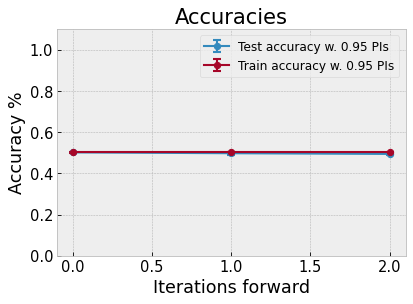

Test accuracies: [0.5016683  0.497576   0.49416845]
Confusion matrices:


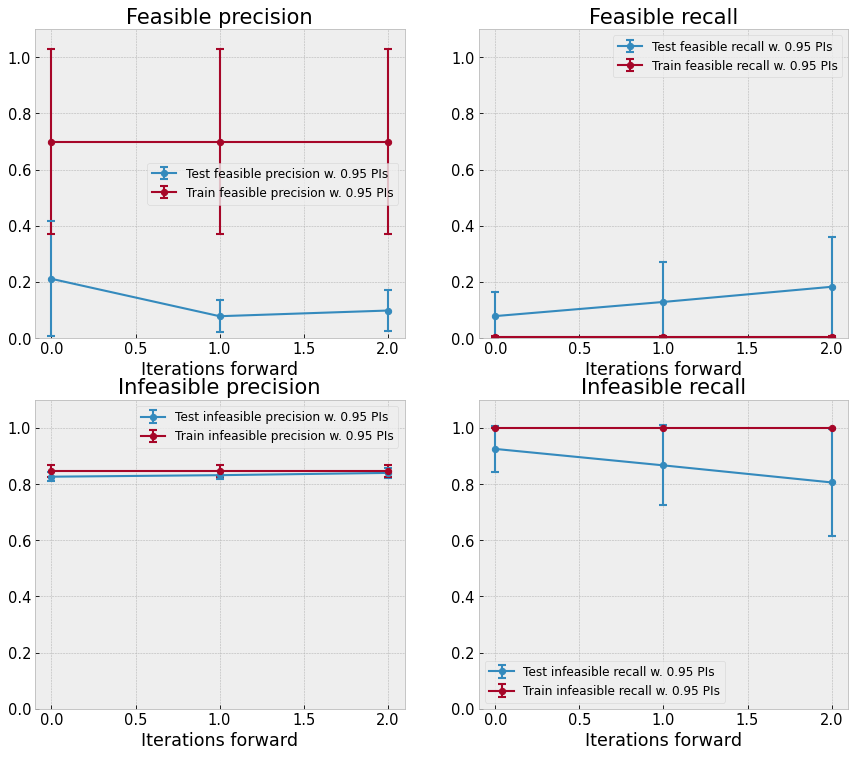

Percentage infeasible on test and train data:


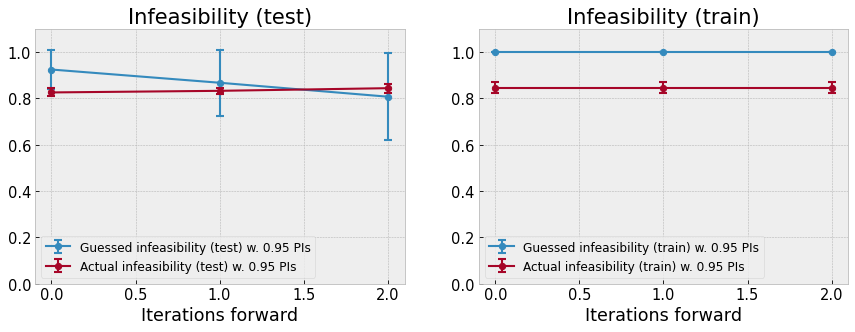

In [16]:
mt.plot_graphs(AUC = False)

# Conclusion

After some hyperparameter tuning we're able to achieve an average balanced accuracy of _just over_ 50%. This is not good at all, just _barely_ better than guessing.

One also notices from the graphs and tables that the predictions are very unstable since the prediction intervals are very large. Sometimes the networks only guesses feasible and sometimes infeasible, there doesn't seem to be a pattern there.

This is why we conclude that the this kind of neural network does not seem able to solve this problem. 